# Снижение размерности

In [1]:
import os
import random
import time
import warnings
from enum import Enum
from os.path import join as pjoin

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml
from matplotlib import rcParams, ticker
from matplotlib.axes import Axes
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.manifold import (
    MDS,
    TSNE,
    Isomap,
    LocallyLinearEmbedding,
    SpectralEmbedding,
)
from sklearn.preprocessing import StandardScaler

%matplotlib inline
rcParams["font.size"] = 14
rcParams["figure.figsize"] = 9, 8

SEED = 314159


def timeit(func):
    def timed(*args, **kwargs):
        ts = time.time()
        result = func(*args, **kwargs)
        te = time.time() - ts
        print(f"func {func.__name__} took {te:.4f} sec")
        return result

    return timed


def seed_everything(seed: int = SEED) -> None:
    random.seed(SEED)
    np.random.seed(SEED)

### Данные

In [2]:
with open("../config.yaml", "r") as f:
    cfg = yaml.safe_load(f)

In [3]:
DatasetT = tuple[pd.DataFrame, pd.Series]

COLUMNS_2D = ["dim1", "dim2"]
COLUMNS_3D = ["dim1", "dim2", "dim3"]


def get_s_curve_dataset(n_samples: int = 1200, seed: int = SEED) -> DatasetT:
    data, labels = datasets.make_s_curve(n_samples, random_state=seed)

    # dim1 and dim3 provides the S-shaped 2D curve
    df, target = pd.DataFrame(data=data, columns=COLUMNS_3D), pd.Series(labels)

    # make a hole
    mask = df["dim1"] ** 2 + (df["dim2"] - 1) ** 2 >= 0.2
    df = df[mask]
    target = target[mask]

    return df, target


def get_circles(
    n_samples: int = 1000, factor: float = 0.5, noise: float = 0.05, seed: int = SEED
) -> DatasetT:
    data, labels = datasets.make_circles(
        n_samples=n_samples, factor=factor, noise=noise, random_state=seed
    )
    return pd.DataFrame(data=data, columns=COLUMNS_2D), pd.Series(labels)


def get_uniform(n_samples: int = 1000) -> DatasetT:
    x = np.linspace(0, 1, int(np.sqrt(n_samples)))
    xx, yy = np.meshgrid(x, x)
    data = np.hstack([xx.ravel().reshape(-1, 1), yy.ravel().reshape(-1, 1)])
    labels = xx.ravel()
    return pd.DataFrame(data=data, columns=COLUMNS_2D), pd.Series(labels)


class FCLabels(Enum):
    NOISE = -1
    DEBRIS = 0
    LYMPH = 1
    MONO = 2
    OTHER = 3


COLUMNS_FC = [
    "FSC-A-",
    "SSC-A-",
    "FITC-A-CD25",
    "PE-A-CD127",
    "PerCP-Cy5-5-A-CD4",
    "PE-Cy7-A-",
    "APC-A-",
    "APC-Cy7-A-",
    "Pacific Blue-A-",
    "AmCyan-A-",
]
COLUMNS_FC_MAIN = ["FSC-A-", "SSC-A-"]


def get_fc_dataset(n_samples: int = 1000, seed: int = SEED) -> DatasetT:
    data_path = pjoin(cfg["flow_cytometry"], "patient_1.csv")
    df: pd.DataFrame = pd.read_csv(data_path, index_col=0)

    # remove some noise
    flow_mask = (df["FSC-A-"] > 200000) | (df["SSC-A-"] > 240000)
    df = df.drop(df[flow_mask].index).reset_index()

    df = df.sample(n=n_samples, random_state=seed)

    # create labels manually
    conditions = [
        (df["FSC-A-"] < 40000) & (df["SSC-A-"] < 35000),
        (df["FSC-A-"].between(35000, 100000)) & (df["SSC-A-"] < 50000),
        (df["FSC-A-"].between(75000, 150000)) & (df["SSC-A-"].between(50000, 90000)),
        (df["FSC-A-"].between(75000, 200000)) & (df["SSC-A-"].between(90000, 250000)),
    ]
    values = [
        FCLabels.DEBRIS.value,
        FCLabels.LYMPH.value,
        FCLabels.MONO.value,
        FCLabels.OTHER.value,
    ]
    labels = np.select(conditions, values, default=FCLabels.NOISE.value)
    target = pd.Series(labels)

    df = df.drop(columns="Time-")

    return df, target


def add_noisy_columns(
    df: pd.DataFrame, n_noisy_cols: int = 0, normal_noise_over_uniform: bool = True
):
    if not n_noisy_cols:
        return df

    df = df.join(
        pd.DataFrame(
            {
                f"_noise_{i}": np.random.normal(0, 1, size=df.shape[0])
                if normal_noise_over_uniform
                else np.random.random(size=df.shape[0])
                for i in range(n_noisy_cols)
            },
            index=df.index,
        )
    )
    return df

In [4]:
def get_datasets() -> dict[str, DatasetT]:
    return {
        "S-curve, 3D": get_s_curve_dataset(),
        "Circles, 2D": get_circles(),
        "Uniform, 2D": get_uniform(),
        "Flow Cytometry, 10D": get_fc_dataset(),
    }

In [5]:
all_datasets = get_datasets()

### Алгоритмы

In [6]:
def get_pca(n_components: int = 2) -> PCA:
    return PCA(n_components=n_components)


def get_mds(
    n_components: int = 2, n_init: int = 1, max_iter: int = 120, n_jobs: int = 4
) -> MDS:
    return MDS(
        n_components=n_components, n_init=n_init, max_iter=max_iter, n_jobs=n_jobs
    )


def get_isomap(n_components: int = 2, n_neighbors: int = 20, n_jobs: int = 4) -> Isomap:
    return Isomap(n_components=n_components, n_neighbors=n_neighbors, n_jobs=n_jobs)


class LLEMethods(Enum):
    STANDARD = "standard"
    HESSIAN = "hessian"
    MODIFIED = "modified"
    LTSA = "ltsa"


def get_lle(
    n_components: int = 2,
    n_neighbors: int = 20,
    method: LLEMethods = LLEMethods.STANDARD,
    seed: int = SEED,
    n_jobs: int = 4,
) -> LocallyLinearEmbedding:
    return LocallyLinearEmbedding(
        n_components=n_components,
        n_neighbors=n_neighbors,
        method=method.value,
        random_state=seed,
        n_jobs=n_jobs,
    )


def get_spectral_embedding(
    n_components: int = 2,
    n_neighbors: int = 20,
    seed: int = SEED,
    n_jobs: int = 4,
) -> SpectralEmbedding:
    return SpectralEmbedding(
        n_components=n_components,
        n_neighbors=n_neighbors,
        random_state=seed,
        n_jobs=n_jobs,
    )


def get_tsne(
    n_components: int = 2,
    perplexity: int = 50,
    n_iter: int = 500,
    init: str = "pca",
    seed: int = SEED,
    n_jobs: int = 4,
) -> TSNE:
    return TSNE(
        n_components=n_components,
        perplexity=perplexity,
        learning_rate="auto",
        n_iter=n_iter,
        init=init,
        random_state=seed,
        n_jobs=n_jobs,
    )

### Визуализация

In [7]:
def plot_2d(
    df: pd.DataFrame,
    target: pd.Series,
    fig_size: tuple[int, int] = (8, 8),
    title: str = "",
    save: bool = True,
    save_path: str | None = None,
) -> None:
    fig, ax = plt.subplots(figsize=fig_size, facecolor="white", constrained_layout=True)

    fig.suptitle(title, size=16)
    add_2d_scatter(ax, df, target)

    if save:
        assert save_path is not None
        fig.savefig(save_path, dpi=150)


def add_2d_scatter(
    ax: Axes,
    df: pd.DataFrame,
    target: pd.Series,
    marker_size: int = 50,
    title: str | None = None,
) -> None:
    x, y = df.iloc[:, 0], df.iloc[:, 1]

    ax.scatter(x, y, c=target, s=marker_size, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())


def plot_3d(
    df: pd.DataFrame,
    target: pd.Series,
    fig_size: tuple[int, int] = (8, 8),
    title: str = "",
    save: bool = True,
    save_path: str | None = None,
) -> None:
    x, y, z = df.iloc[:, 0], df.iloc[:, 1], df.iloc[:, 2]

    fig, ax = plt.subplots(
        figsize=fig_size,
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    fig.suptitle(title, size=16)

    col = ax.scatter(x, y, z, c=target, s=50, alpha=0.8)
    ax.view_init(azim=-60, elev=9)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.zaxis.set_major_locator(ticker.MultipleLocator(1))

    fig.colorbar(col, ax=ax, orientation="vertical", shrink=0.5, aspect=30, pad=0.01)

    if save:
        assert save_path is not None
        fig.savefig(save_path, dpi=150)


def plot_pairplot_fc(df: pd.DataFrame, target: pd.Series, save_path: str) -> None:
    df_new = df.copy()
    labels = target.map({-1: "Noise", 0: "Debris", 1: "Lymph", 2: "Mono", 3: "Other"})
    df_new = df_new[df_new.columns[:5]]
    df_new[df_new.columns] = StandardScaler().fit_transform(df_new)
    df_new["labels"] = labels.values
    sns.pairplot(df_new, hue="labels", diag_kind="hist").figure.savefig(
        save_path, dpi=150
    );

### Анализ

In [8]:
RESULTS_DIR = "results"
os.makedirs("results", exist_ok=True)

In [9]:
def plot_all_datasets(all_datasets: dict[str, DatasetT]) -> None:
    df, target = all_datasets["Flow Cytometry, 10D"]
    plot_2d(
        df=df[COLUMNS_FC_MAIN],
        target=target,
        title="Flow Cytometry, 10D",
        save_path=pjoin(RESULTS_DIR, "dataset_fc.png"),
    )
    plot_pairplot_fc(
        df=df, target=target, save_path=pjoin(RESULTS_DIR, "dataset_fc_pairplot.png")
    )

    df, target = all_datasets["S-curve, 3D"]
    plot_3d(
        df=df,
        target=target,
        title="S-curve",
        save_path=pjoin(RESULTS_DIR, "dataset_s_curve.png"),
    )

    df, target = all_datasets["Circles, 2D"]
    plot_2d(
        df=df,
        target=target,
        title="Circles",
        save_path=pjoin(RESULTS_DIR, "dataset_circles.png"),
    )

    df, target = all_datasets["Uniform, 2D"]
    plot_2d(
        df, target, title="Uniform", save_path=pjoin(RESULTS_DIR, "dataset_uniform.png")
    )


def run_experiment_pca(seed: int = SEED):
    seed_everything(seed)
    df, target = get_s_curve_dataset()

    def _run_experiment(
        title: str,
        save_path: str,
        n_noisy_cols: int = 0,
        with_mean: bool = True,
        with_std: bool = False,
    ) -> None:
        df_test = df.copy()
        if n_noisy_cols:
            df_test = add_noisy_columns(df_test, n_noisy_cols)

        scaler = StandardScaler(with_mean=with_mean, with_std=with_std)
        df_test[COLUMNS_3D] = scaler.fit_transform(df_test[COLUMNS_3D])

        pca = get_pca(n_components=2)
        df_embedding = pd.DataFrame(
            columns=COLUMNS_2D, data=pca.fit_transform(df_test, target)
        )

        plot_2d(df_embedding, target, title=title, save_path=save_path)

    _run_experiment(
        with_std=False,
        title="PCA, minus mean",
        save_path=pjoin(RESULTS_DIR, "exp_1_pca_1.png"),
    )
    _run_experiment(
        with_std=True,
        title="PCA, normalized",
        save_path=pjoin(RESULTS_DIR, "exp_1_pca_2.png"),
    )
    _run_experiment(
        with_std=False,
        n_noisy_cols=7,
        title="PCA, minus mean + 7 noisy columns",
        save_path=pjoin(RESULTS_DIR, "exp_1_pca_3.png"),
    )


def run_experiment_comparison(
    all_datasets: dict[str, DatasetT],
    add_noise: bool = False,
    normal_noise_over_uniform: bool = False,
    seed: int = SEED,
) -> None:
    seed_everything(seed)

    methods = {
        "PCA": get_pca(),
        "MDS": get_mds(),
        "Isomap": get_isomap(),
        "LLE": get_lle(),
        "Modified LLE": get_lle(method=LLEMethods.MODIFIED),
        "Spectral": get_spectral_embedding(),
        "t-SNE": get_tsne(),
    }
    datasets = prepare_datasets_for_comparison(
        all_datasets, add_noise, normal_noise_over_uniform
    )

    fig, axes = plt.subplots(len(all_datasets), len(methods) + 1, figsize=(18, 8))
    for i, (dataset_name, (df, target)) in enumerate(datasets.items()):
        add_2d_scatter(
            axes[i, 0],
            df.iloc[:, :2],
            target,
            marker_size=10,
            title=dataset_name,
        )
        for j, (method_name, method) in enumerate(methods.items()):
            df_embedding = pd.DataFrame(
                columns=COLUMNS_2D, data=method.fit_transform(df, target)
            )
            add_2d_scatter(
                axes[i, j + 1], df_embedding, target, marker_size=5, title=method_name
            )

    noise_type = "normal" if normal_noise_over_uniform else "uniform"
    dataset_type = "general" if not add_noise else noise_type
    filename = f"exp_2_{dataset_type}.png"
    fig.savefig(pjoin(RESULTS_DIR, filename), dpi=150)


def prepare_datasets_for_comparison(
    all_datasets: dict[str, DatasetT],
    add_noise: bool = False,
    normal_noise_over_uniform: bool = False,
) -> dict[str, DatasetT]:
    datasets = {}
    scaler = StandardScaler()
    for dataset_name, (df, target) in all_datasets.items():
        df_new = df.copy()
        if add_noise:
            df_new = add_noisy_columns(
                df_new,
                n_noisy_cols=15 - df_new.shape[1],
                normal_noise_over_uniform=normal_noise_over_uniform,
            )
        df_new[df_new.columns] = scaler.fit_transform(df_new)

        if dataset_name == "S-curve, 3D":
            df_new[["dim2", "dim3"]] = df_new[["dim3", "dim2"]]

        datasets[dataset_name] = (df_new, target)

    return datasets

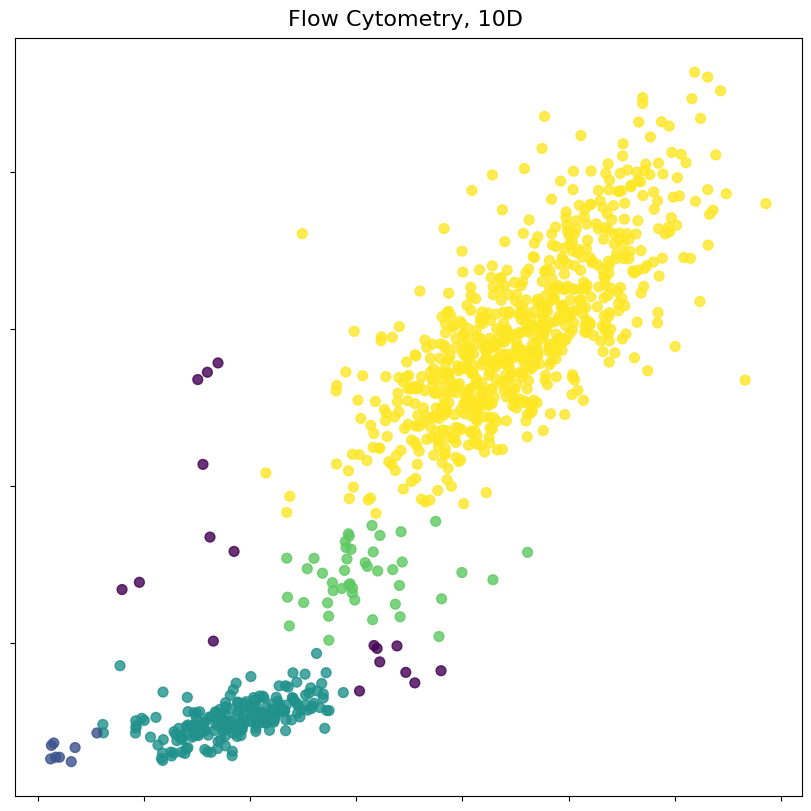

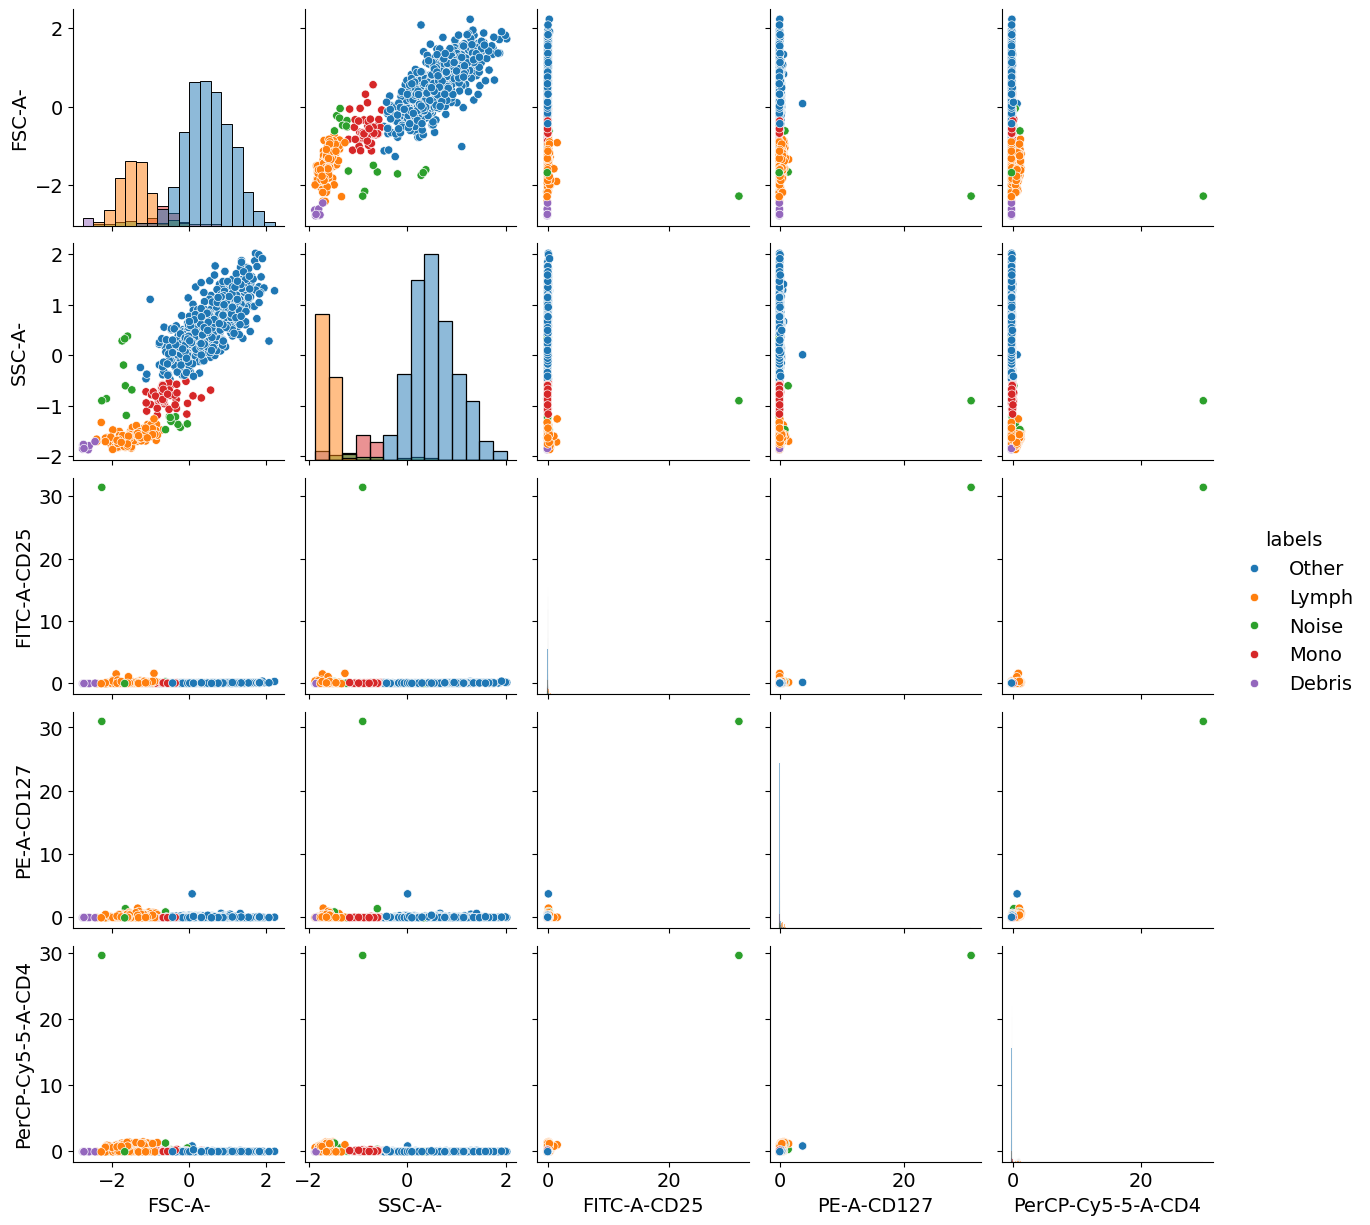

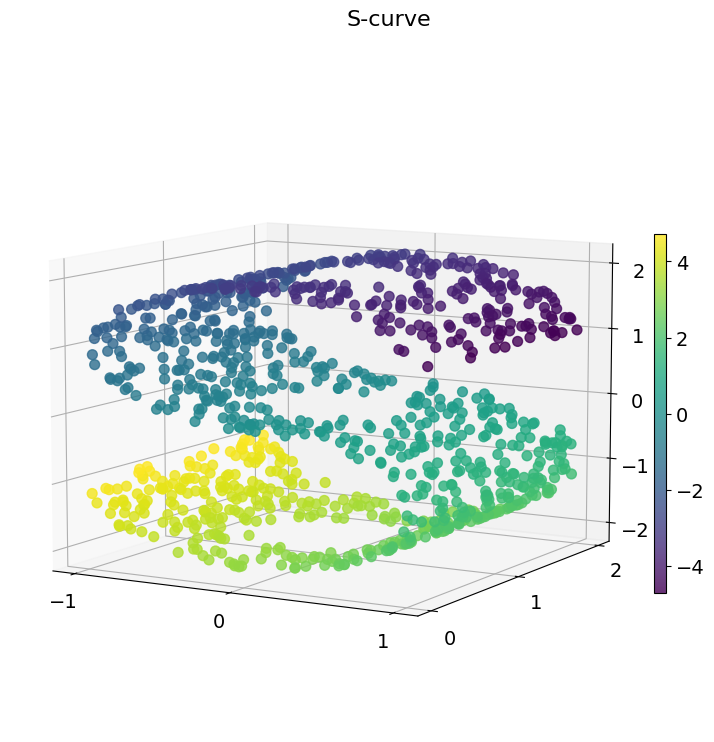

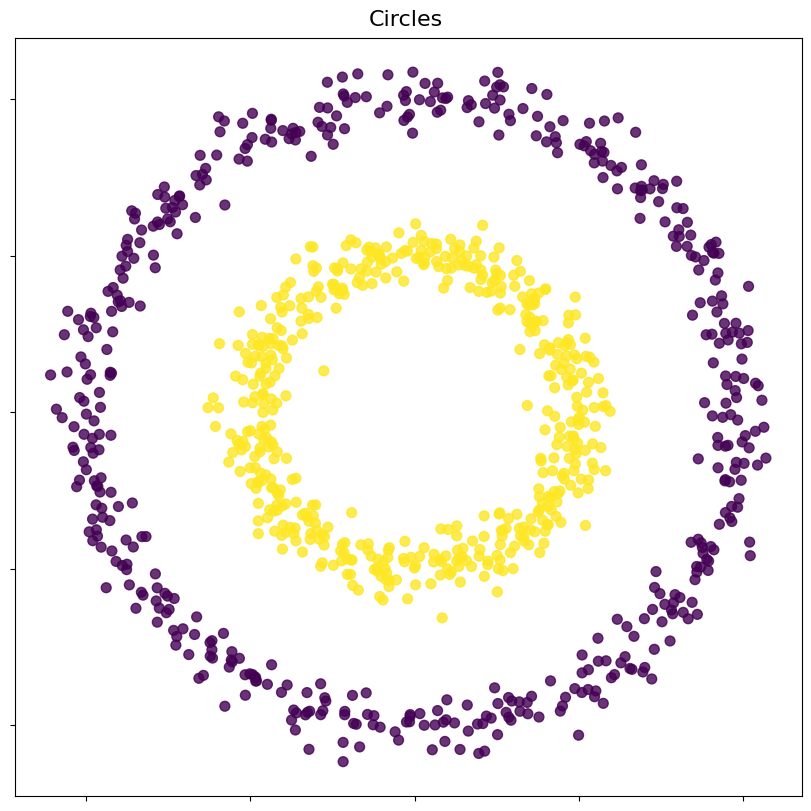

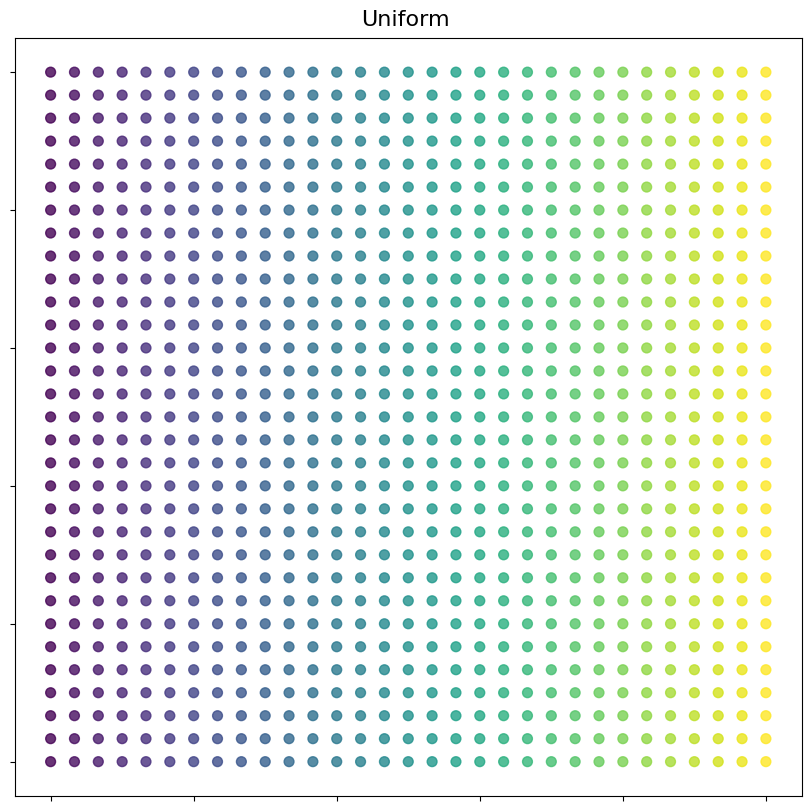

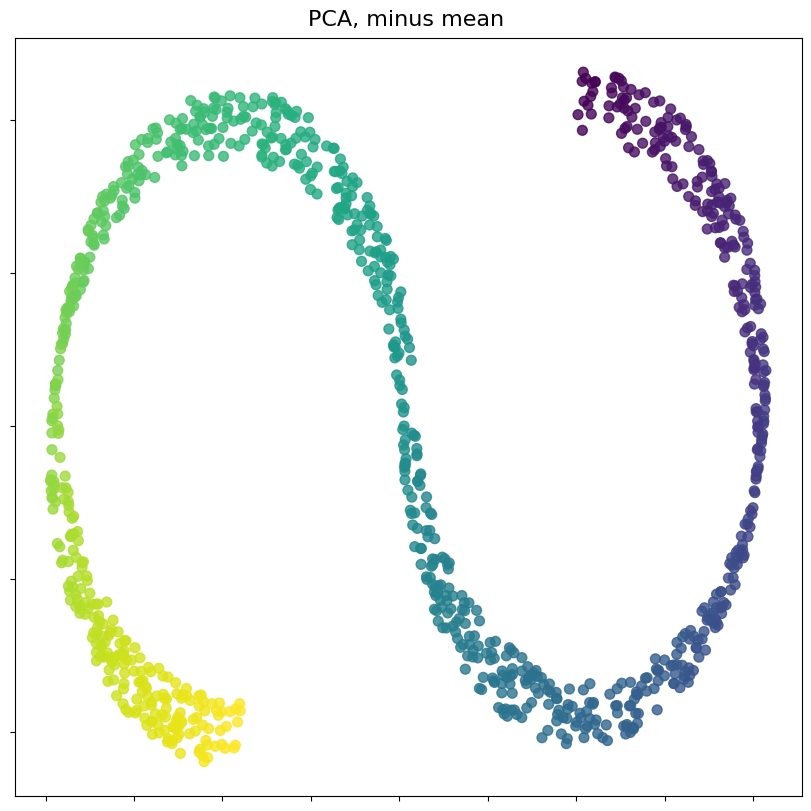

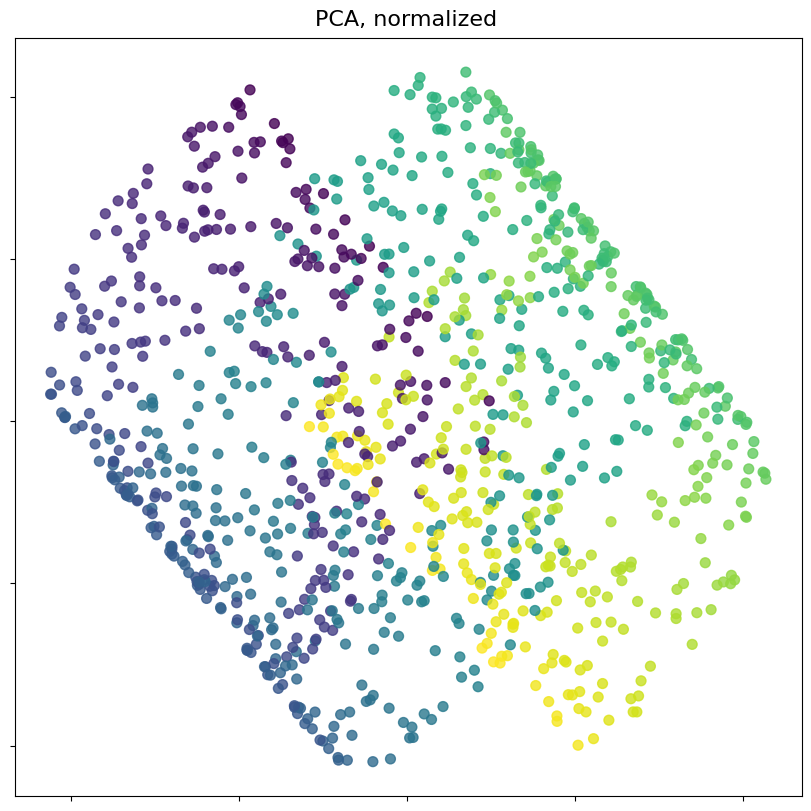

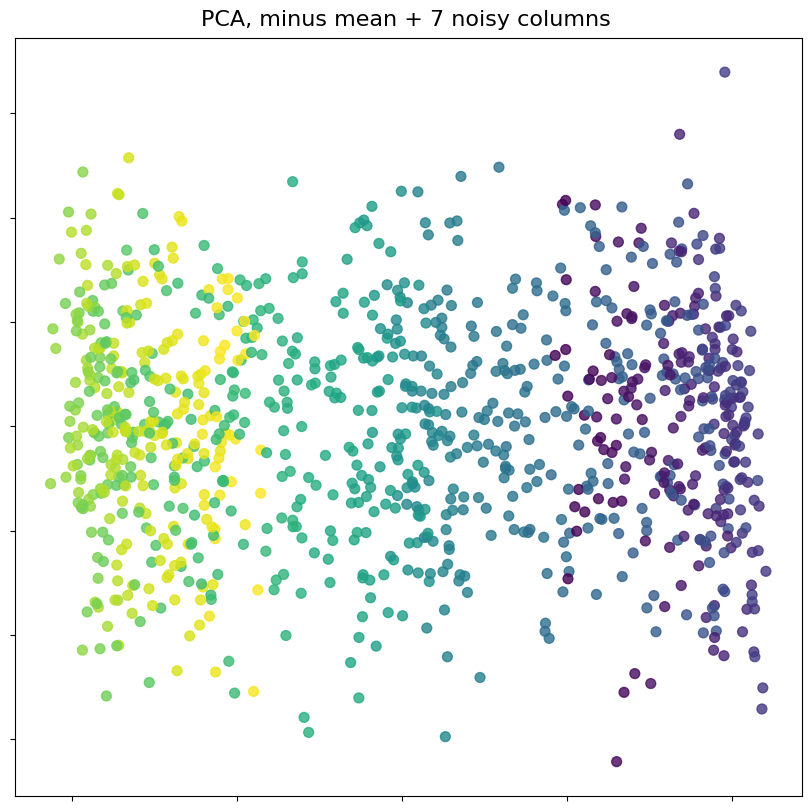

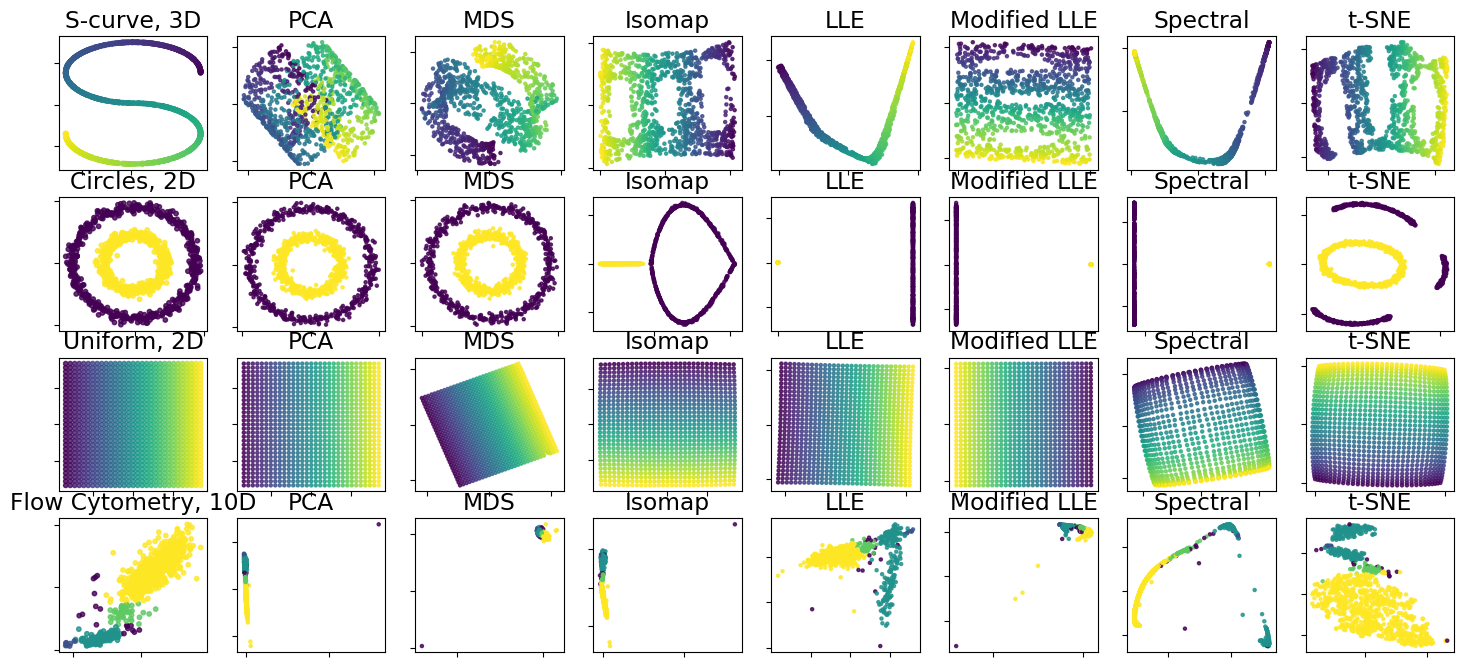

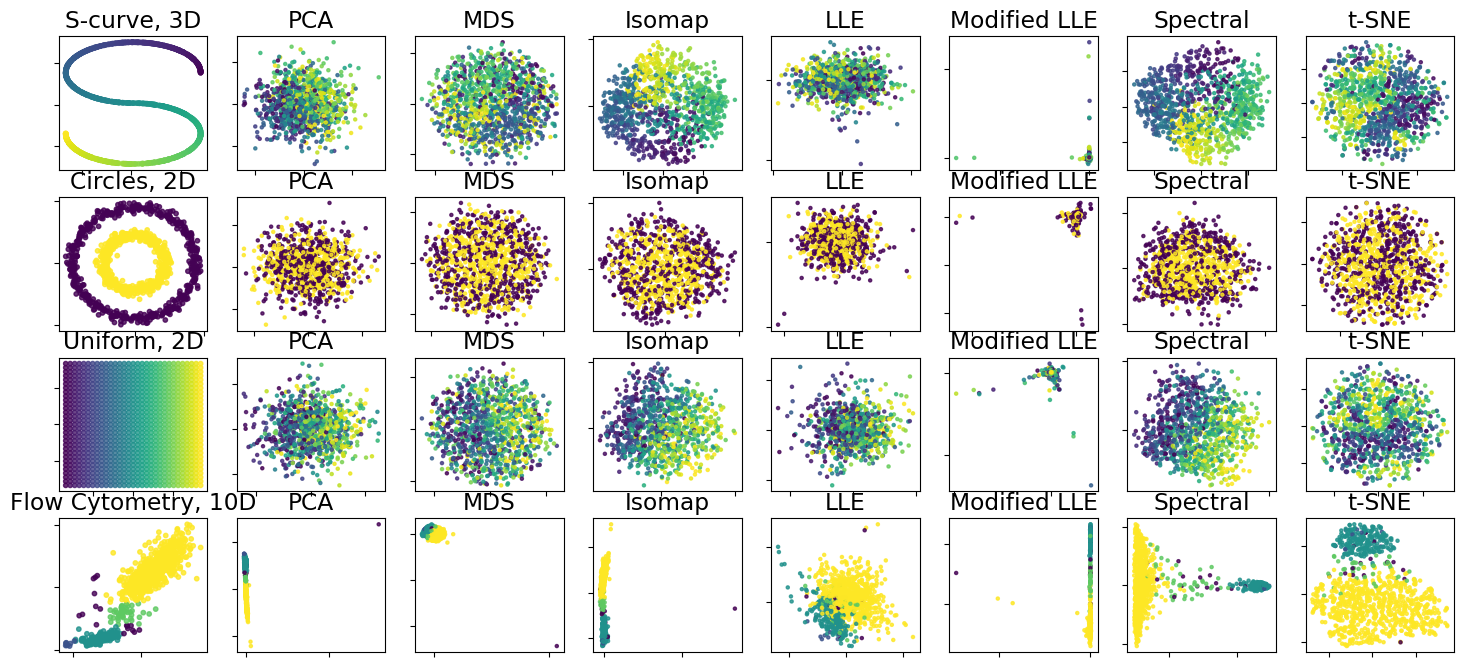

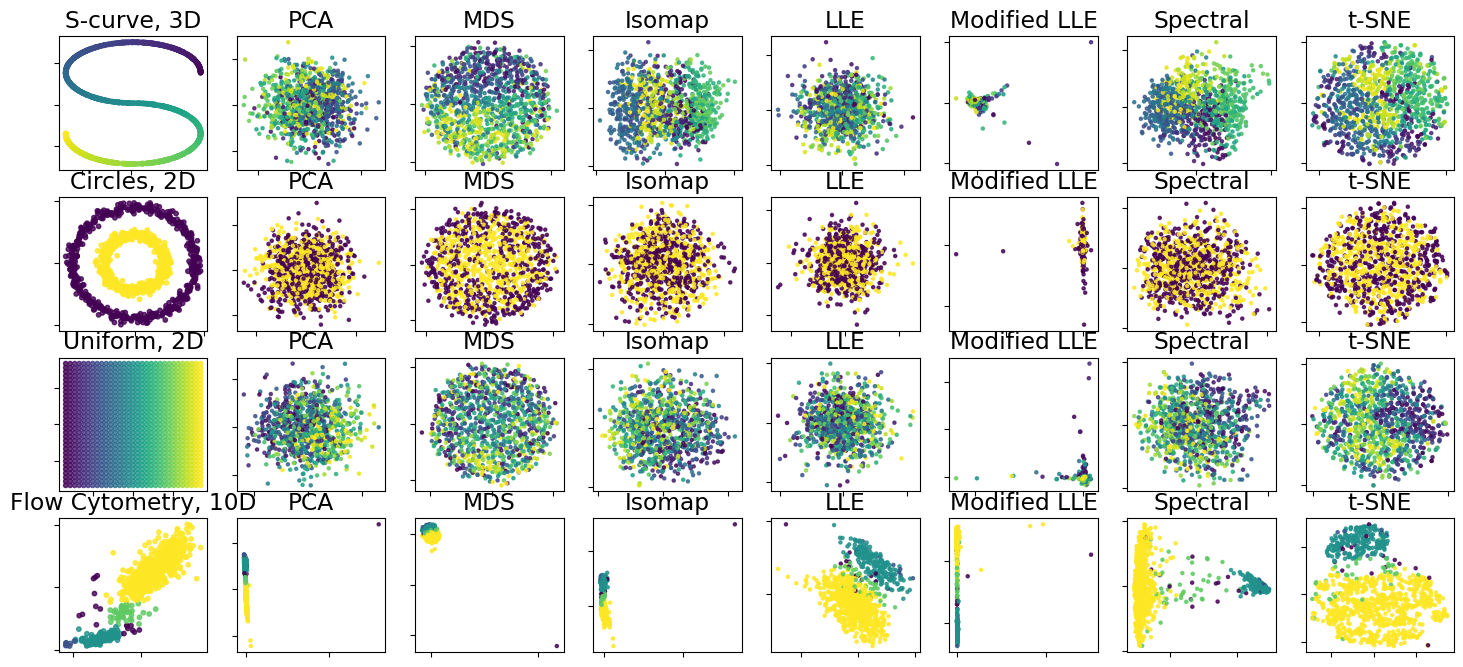

In [10]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_all_datasets(all_datasets)
    run_experiment_pca()
    run_experiment_comparison(all_datasets, add_noise=False)
    run_experiment_comparison(
        all_datasets, add_noise=True, normal_noise_over_uniform=True
    )
    run_experiment_comparison(
        all_datasets, add_noise=True, normal_noise_over_uniform=False
    )